# Flagging

Demonstration of prototype ngCASA flagging functions. This is work in progress.

This walkthrough is designed to be run in a Jupyter notebook on Google Colaboratory. To open the notebook in colab, go [here](https://colab.research.google.com/github/FedeMPouzols/cngi_prototype/blob/ngcasa_flagging_experiments/docs/flagging.ipynb)



## Get required packages and data

In [29]:
# Installation
import os
# (WIP note: we might get by without casatools, if we prepare some .vis.zarr available for download re-check)
print("installing casa6 + cngi (takes a minute or two)...")
!apt-get install libgfortran3
#os.system("pip install --index-url https://casa-pip.nrao.edu/repository/pypi-casa-release/simple casatools==6.1.0.118")
!pip install --upgrade --index-url https://casa-pip.nrao.edu:443/repository/pypi-group/simple casatools casatasks

installing casa6 + cngi (takes a minute or two)...
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgfortran3 is already the newest version (6.5.0-2ubuntu1~18.04).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.
Looking in indexes: https://casa-pip.nrao.edu:443/repository/pypi-group/simple
Requirement already up-to-date: casatools in /usr/local/lib/python3.7/dist-packages (6.2.0.96)
Requirement already up-to-date: casatasks in /usr/local/lib/python3.7/dist-packages (6.2.0.97)


In [23]:
!pip install cngi-prototype==0.0.67

In [10]:
# Retrieve and extract demonstration datasets
print('retrieving MS tarfiles...')
!gdown -q --id 15HfB4rJKqEH7df088Ge5YLrCTXBIax6R
!gdown -q --id 1N9QSs2Hbhi-BrEHx5PA54WigXt8GGgx1
print('extracting MS tarfiles...')
!tar -xf M100.ms.tar
!tar -xzf sis14_twhya_calibrated_flagged.ms.tar.gz
# TODO: download the ".flagonline.txt" file
print('complete')

retrieving MS tarfiles...
extracting MS tarfiles...
complete


## Initialize the Environment
Omitting for now. I think we don't need it here and it shouldn't show up here at the ngCASA level anyway.

## Load demo data

In [24]:
#os.system("python -m casatools --update-user-data")
!pip install --index-url=https://go.nrao.edu/pypi casadata

Looking in indexes: https://go.nrao.edu/pypi


In [25]:
from cngi.conversion import convert_ms

zarr_name = 'twhya.vis.zarr' 
mxds = convert_ms('sis14_twhya_calibrated_flagged.ms', outfile=zarr_name) 

ImportError: ignored

In [26]:
from cngi.dio import describe_vis 
describe_vis(zarr_name)
# We will be working with the only SPW present in this dataset
vis_dset = mxds.xds0

FileNotFoundError: ignored

## Flag summaries
Summaries of flags by different dimensions in a dictionary, similar to the dictionary produce by CASA flagdata in 'summary' mode.

In [ ]:
from ngcasa.flagging import summary
# <temporary hack>
mxds.xds0['presence_baseline'] = mxds.xds0.DATA.notnull().any(['chan', 'pol'])
# </temporary hack>
# Get the initial flagging status
counts = summary(mxds, 0)
counts

{'correlation': {'XX': {'flagged': 22800, 'total': 30936192},
  'YY': {'flagged': 22800, 'total': 30936192}},
 'total': 61872384,
 'flagged': 45600,
 'array': {'0': {'flagged': 45600, 'total': 61872384}},
 'scan': {'4': {'flagged': 0, 'total': 3225600},
  '7': {'flagged': 45600, 'total': 2918400},
  '10': {'flagged': 0, 'total': 1459200},
  '12': {'flagged': 0, 'total': 6538752},
  '14': {'flagged': 0, 'total': 1459200},
  '16': {'flagged': 0, 'total': 7956480},
  '18': {'flagged': 0, 'total': 1612800},
  '20': {'flagged': 0, 'total': 7926528},
  '22': {'flagged': 0, 'total': 1612800},
  '24': {'flagged': 0, 'total': 7928832},
  '26': {'flagged': 0, 'total': 1612800},
  '28': {'flagged': 0, 'total': 7266816},
  '30': {'flagged': 0, 'total': 1459200},
  '33': {'flagged': 0, 'total': 2612736},
  '34': {'flagged': 0, 'total': 1459200},
  '36': {'flagged': 0, 'total': 3210240},
  '38': {'flagged': 0, 'total': 1612800}},
 'observation': {'0': {'flagged': 45600, 'total': 61872384}},
 'field'

## Handling flag versions




In [ ]:
from ngcasa.flagging import manager_list, manager_add, manager_remove
print('* Printing list of flag variables - checkpoint 0:')
versions = manager_list(vis_dset)
print(versions)

vis_flags = manager_add(vis_dset, 'start', 'flags state at start')
# vis_flags = manual_unflag(vis_flags, [{'time': slice('2011-09-16T15:38:17','2011-10-16T18:39:50')}])
vis_flags = manager_add(vis_flags, 'backup', 'backup description')
#
vis_flags = manager_add(vis_flags, 'final', 'backup second descr')
#
print('* Printing list - checkpoint A:')
versions = manager_list(vis_flags)
print(versions)

# fxds['FLAG'] = fxds['FLAG_final']
vis_flags['FLAG'] = vis_flags['FLAG_backup'] | vis_flags['FLAG_start']

# We can always drop versions that are no longer useful
vis_flags = manager_remove(vis_flags, 'start')
vis_flags = manager_remove(vis_flags, 'backup')
vis_flags = manager_remove(vis_flags, 'final')
print('* Printing list - checkpoint B:')
versions = manager_list(vis_flags)
print(versions)
# FLAG variables as added as regular data variables in the xarray Datasets
# An aditional attribute (flag_variables) are added for bookkeeping
vis_flags

* Printing list of flag variables - checkpoint 0:
     Flag variable name                                  Description
0                  FLAG                       Default flags variable
1      FLAG_checkpointA  after a couple of example manual selections
2      FLAG_manual_sels            after applying a few manual flags
3   FLAG_auto_clip_test                          after applying clip
4  FLAG_auto_clip_test1                          after applying clip
* Printing list - checkpoint A:
     Flag variable name                                  Description
0                  FLAG                       Default flags variable
1      FLAG_checkpointA  after a couple of example manual selections
2      FLAG_manual_sels            after applying a few manual flags
3   FLAG_auto_clip_test                          after applying clip
4  FLAG_auto_clip_test1                          after applying clip
5            FLAG_start                         flags state at start
6           FLAG_back

<xarray.Dataset>
Dimensions:               (baseline: 210, chan: 384, pol: 2, pol_id: 1, spw_id: 1, time: 410, uvw_index: 3)
Coordinates:
  * baseline              (baseline) int64 0 1 2 3 4 5 ... 205 206 207 208 209
  * chan                  (chan) float64 3.725e+11 3.725e+11 ... 3.728e+11
    chan_width            (chan) float64 dask.array<chunksize=(384,), meta=np.ndarray>
    effective_bw          (chan) float64 dask.array<chunksize=(384,), meta=np.ndarray>
  * pol                   (pol) int32 9 12
  * pol_id                (pol_id) int32 0
    resolution            (chan) float64 dask.array<chunksize=(384,), meta=np.ndarray>
  * spw_id                (spw_id) int32 0
  * time                  (time) datetime64[ns] 2012-11-19T07:37:00 ... 2012-...
Dimensions without coordinates: uvw_index
Data variables:
    ANTENNA1              (time, baseline) int32 dask.array<chunksize=(100, 210), meta=np.ndarray>
    ANTENNA2              (time, baseline) int32 dask.array<chunksize=(100, 210), meta=np.ndarray>
    ARRAY_ID              (time, baseline) int32 dask.array<chunksize=(100, 210), meta=np.ndarray>
    DATA                  (time, baseline, chan, pol) complex128 dask.array<chunksize=(100, 210, 32, 1), meta=np.ndarray>
    EXPOSURE              (time, baseline) float64 dask.array<chunksize=(100, 210), meta=np.ndarray>
    FEED1                 (time, baseline) int32 dask.array<chunksize=(100, 210), meta=np.ndarray>
    FEED2                 (time, baseline) int32 dask.array<chunksize=(100, 210), meta=np.ndarray>
    FIELD_ID              (time, baseline) int32 dask.array<chunksize=(100, 210), meta=np.ndarray>
    FLAG                  (time, baseline, chan, pol) bool dask.array<chunksize=(100, 210, 32, 1), meta=np.ndarray>
    INTERVAL              (time, baseline) float64 dask.array<chunksize=(100, 210), meta=np.ndarray>
    OBSERVATION_ID        (time, baseline) int32 dask.array<chunksize=(100, 210), meta=np.ndarray>
    PROCESSOR_ID          (time, baseline) int32 dask.array<chunksize=(100, 210), meta=np.ndarray>
    SCAN_NUMBER           (time, baseline) int32 dask.array<chunksize=(100, 210), meta=np.ndarray>
    STATE_ID              (time, baseline) int32 dask.array<chunksize=(100, 210), meta=np.ndarray>
    TIME_CENTROID         (time, baseline) float64 dask.array<chunksize=(100, 210), meta=np.ndarray>
    UVW                   (time, baseline, uvw_index) float64 dask.array<chunksize=(100, 210, 3), meta=np.ndarray>
    WEIGHT                (time, baseline, chan, pol) float64 dask.array<chunksize=(100, 210, 32, 1), meta=np.ndarray>
    presence_baseline     (time, baseline) bool dask.array<chunksize=(100, 210), meta=np.ndarray>
    FLAG_checkpointA      (time, baseline, chan, pol) bool dask.array<chunksize=(100, 210, 32, 1), meta=np.ndarray>
    FLAG_manual_sels      (time, baseline, chan, pol) bool dask.array<chunksize=(100, 210, 32, 1), meta=np.ndarray>
    FLAG_auto_clip_test   (time, baseline, chan, pol) bool dask.array<chunksize=(100, 210, 32, 1), meta=np.ndarray>
    FLAG_auto_clip_test1  (time, baseline, chan, pol) bool dask.array<chunksize=(100, 210, 32, 1), meta=np.ndarray>
    FLAG_start            (time, baseline, chan, pol) bool dask.array<chunksize=(100, 210, 32, 1), meta=np.ndarray>
    FLAG_backup           (time, baseline, chan, pol) bool dask.array<chunksize=(100, 210, 32, 1), meta=np.ndarray>
    FLAG_final            (time, baseline, chan, pol) bool dask.array<chunksize=(100, 210, 32, 1), meta=np.ndarray>
Attributes:
    assoc_nature:     ['', '', '', '', '', '', '', '', '', '', '', '', '', ''...
    bbc_no:           2
    corr_product:     [[0, 0], [1, 1]]
    freq_group:       0
    freq_group_name:  
    if_conv_chain:    0
    meas_freq_ref:    5
    name:             ALMA_RB_07#BB_2#SW-01#FULL_RES
    net_sideband:     2
    num_chan:         384
    num_corr:         2
    ref_frequency:    372533086425.9812
    total_bandwidth:  234375000.0
    flag_variables:   {'FLAG': 'Default flags variab

## Running flagging methods
A few illustrative examples, trying to cover all the categories of flagging methods.



### Manual flagging and meta-information based methods
Methods based on data selection and/or meta-information. Simple examples with data selection based flagging and unflagging.

In [ ]:
from ngcasa.flagging import manual_flag, manual_unflag

vis_dset = mxds.xds0
#
vis_dset = manager_add(vis_dset, 'checkpointA', 'after a couple of example manual selections')
#
vis_dset = manager_add(vis_dset, 'manual_sels', 'after applying a few manual flags')

# unflag one antenna (not present)
vis_partial = manual_unflag(mxds, 0, [{'antenna': 'DV01'}])
# unflag one antenna (present)
vis_partial = manual_unflag(mxds, 0, [{'antenna': 'DV02'}])
# unflag all
vis_unflagged = manual_unflag(mxds, 0, [])
# <horror> figure out how to deal with return mxds (use cngi._utils._io.vis_xds_packager?)
mxds.xds0['FLAG'] = vis_unflagged['FLAG']
# </horror>
counts = summary(mxds, 0)
print('* Flags after unflagging:')
counts

 *** Going for cmd: {'antenna': 'DV01'}, selection: {'baseline': array([], dtype=int64)}
 *** Going for cmd: {'antenna': 'DV02'}, selection: {'baseline': array([119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
         6,  25,  43,  60,  76,  91, 105])}
* Flags after unflagging:


{'correlation': {'XX': {'flagged': 0, 'total': 30936192},
  'YY': {'flagged': 0, 'total': 30936192}},
 'total': 61872384,
 'flagged': 0,
 'array': {'0': {'flagged': 0, 'total': 61872384}},
 'scan': {'4': {'flagged': 0, 'total': 3225600},
  '7': {'flagged': 0, 'total': 2918400},
  '10': {'flagged': 0, 'total': 1459200},
  '12': {'flagged': 0, 'total': 6538752},
  '14': {'flagged': 0, 'total': 1459200},
  '16': {'flagged': 0, 'total': 7956480},
  '18': {'flagged': 0, 'total': 1612800},
  '20': {'flagged': 0, 'total': 7926528},
  '22': {'flagged': 0, 'total': 1612800},
  '24': {'flagged': 0, 'total': 7928832},
  '26': {'flagged': 0, 'total': 1612800},
  '28': {'flagged': 0, 'total': 7266816},
  '30': {'flagged': 0, 'total': 1459200},
  '33': {'flagged': 0, 'total': 2612736},
  '34': {'flagged': 0, 'total': 1459200},
  '36': {'flagged': 0, 'total': 3210240},
  '38': {'flagged': 0, 'total': 1612800}},
 'observation': {'0': {'flagged': 0, 'total': 61872384}},
 'field': {'J0522-364': {'flagge

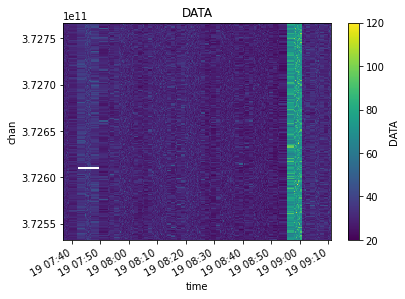

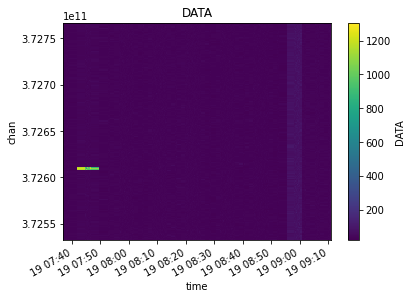

In [ ]:
from cngi.vis import applyflags
from cngi.vis import visplot
flagged_manual = applyflags(vis_dset, flags=['FLAG'])
plot_axes = ['time', 'chan']
visplot(flagged_manual.DATA, plot_axes)
visplot(vis_dset.DATA, plot_axes)


### Manual flagging with command lists
An example of application of a list of manual flagging commands, resembling use cases from pipelines. An additional required input is the file of flagging commands. Here we use a `.flagonline.txt` file as used in pipelines, where we usually find of the order of 1000s or 10s of thousands of commands. The `.flagonline.txt` is the lion's share of the full list of commands used by pipelines (`.flagcmds.txt`), where the `.flagonline.txt` list of commands is extended with a much shorter list of additional commands that may include a number of summaries, selections based on intent and frequency, the shadow method, etc.

The selection syntax used is the Xarray selection syntax (see examples in the [Visibilities walkthrough ](visibilities.ipynb)), with selection by label `xds.sel(...)`.

In [ ]:
vis_flags = manual_unflag(mxds, 0, [{'time': slice('2011-09-16T15:38:17','2011-10-16T18:39:50')}])
#
vis_flags = manual_unflag(mxds, 0, [{}])

# Flag two groups of adjacent ~20 chans
vis_flags = manual_flag(mxds, 0, [{'chan': slice(3.7266e11, 3.7271e11)}, 
                                  {'chan': slice(3.7276e9, 3.728e11)}])

# Flag some baselines, by ID
vis_flags = manual_flag(mxds, 0, [{'baseline': [133, 134, 135]}])
# Flag polarization, by ID
vis_flgs = manual_flag(mxds, 0, [{'pol': 9}])

# vis_dset = manual_flag(vis_dset, cmdfile='.flagonline.txt')
vis_flags = manager_add(vis_flags, 'manual_list', 'after applying list of selection commands')


# <horror> figure out how to deal with return mxds (use cngi._utils._io.vis_xds_packager?)
mxds.xds0['FLAG'] = vis_flags['FLAG']
# </horror>
print('* Printing list - after flagging:')
versions = manager_list(vis_flags)
print(versions)

# vis_flags = manual_flag(mxds, 0, cmd_filename='short_twhya.flagonline.txt')

print('* Flags after flagging some channels and baselines:')
counts = summary(mxds, 0)
print(counts)

* Flags before unflagging/flagging:
{'correlation': {'XX': {'flagged': 30936192, 'total': 30936192}, 'YY': {'flagged': 30936192, 'total': 30936192}}, 'total': 61872384, 'flagged': 61872384, 'array': {'0': {'flagged': 61872384, 'total': 61872384}}, 'scan': {'4': {'flagged': 3225600, 'total': 3225600}, '7': {'flagged': 2918400, 'total': 2918400}, '10': {'flagged': 1459200, 'total': 1459200}, '12': {'flagged': 6538752, 'total': 6538752}, '14': {'flagged': 1459200, 'total': 1459200}, '16': {'flagged': 7956480, 'total': 7956480}, '18': {'flagged': 1612800, 'total': 1612800}, '20': {'flagged': 7926528, 'total': 7926528}, '22': {'flagged': 1612800, 'total': 1612800}, '24': {'flagged': 7928832, 'total': 7928832}, '26': {'flagged': 1612800, 'total': 1612800}, '28': {'flagged': 7266816, 'total': 7266816}, '30': {'flagged': 1459200, 'total': 1459200}, '33': {'flagged': 2612736, 'total': 2612736}, '34': {'flagged': 1459200, 'total': 1459200}, '36': {'flagged': 3210240, 'total': 3210240}, '38': {'f

### Auto-flagging methods
An illustrative example using the `auto_clip` method. Other auto-flagging methods such as tfcrop, rflag, and uvbin are not implemented.

     Flag variable name                                  Description
0                  FLAG                       Default flags variable
1      FLAG_checkpointA  after a couple of example manual selections
2      FLAG_manual_sels            after applying a few manual flags
3   FLAG_auto_clip_test                          after applying clip
4  FLAG_auto_clip_test1                          after applying clip
{'correlation': {'XX': {'flagged': 18188057, 'total': 30936192}, 'YY': {'flagged': 21372640, 'total': 30936192}}, 'total': 61872384, 'flagged': 39560697, 'array': {'0': {'flagged': 39560697, 'total': 61872384}}, 'scan': {'4': {'flagged': 1703342, 'total': 3225600}, '7': {'flagged': 1640010, 'total': 2918400}, '10': {'flagged': 916646, 'total': 1459200}, '12': {'flagged': 3937827, 'total': 6538752}, '14': {'flagged': 944994, 'total': 1459200}, '16': {'flagged': 5223110, 'total': 7956480}, '18': {'flagged': 1092566, 'total': 1612800}, '20': {'flagged': 5029885, 'total': 7926528}, '

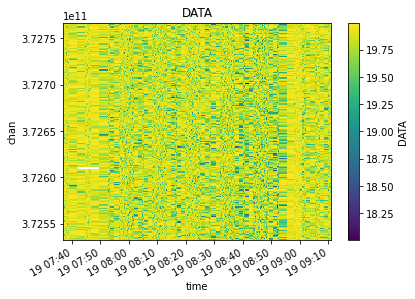

In [ ]:
from ngcasa.flagging import auto_clip
# 
# vis_dset = manager_add(vis_dset, 'auto_clip_test1', 'after applying clip')
versions = manager_list(vis_dset)
print(versions)

vis_clip = auto_clip(vis_dset, 10, 35)
# <horror> figure out how to deal with return mxds (use cngi._utils._io.vis_xds_packager?)
mxds.xds0['FLAG'] = vis_clip['FLAG']
# </horror>
counts_clip = summary(mxds, 0)
print(counts_clip)

flagged_clip = applyflags(vis_clip, flags=['FLAG'])
plot_axes = ['time', 'chan']
visplot(flagged_clip.DATA, plot_axes)

## Applying flags
To apply a version of flags on a visibilities dataset, before going on to further processing, the function `cngi.vis.applyflags` should be applied. Some examples can be found in the [Continuum Imaging Example](imaging/continuum_imaging_example.ipynb) or the [Visibilities walkthrough](visibilities.ipynb). `cngi.vis.applyflags` sets the flagged data values to NaN. This has the effect that those NaN values are effectively excluded from subsequent CNGI/ngCASA processing. Other components of CNGI and ngCASA, such as imaging, will ignore those NaN values.

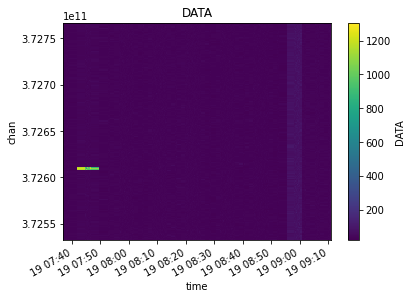

In [ ]:
from cngi.vis import applyflags
from cngi.vis import visplot

versions = manager_list(vis_dset)
versions

plot_coords = ['time', 'chan']
visplot(vis_dset.DATA, plot_coords)
vis_dataset_flagged = applyflags(vis_dset, flags=['FLAG'])
# Further processing: visualization, calibration, imaging, etc. with flags applied (flagged data excluded)
# ...

#flagged_manual = applyflags(vis_dset, flags=['FLAG_MANUAL_LIST'])
#visplot(flagged_manual.DATA, plot_coords)

#flagged_clip = applyflags(vis_dset, flags=['FLAG_AUTO_CLIP'])
#visplot(flagged_clip.DATA, plot_coords)